In [2]:
import torch
from resnet_instance_norm import ResNet
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn as nn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [4]:
def resnet_6n_2(n, r):
    """
    This creates a ResNet model with 5 residual blocks 
    in each of the three sets of hidden layers, 
    and a fully connected output layer with 10 units.
    """
    return ResNet(n, r)

In [5]:
model = resnet_6n_2(2, 10).to(device)

In [6]:
model

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): MyInstanceNorm()
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): MyInstanceNorm()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): MyInstanceNorm()
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): MyInstanceNorm()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): MyInstanceNorm()
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  

In [7]:
data_path = "../data"

In [8]:
batch_size = 128
# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root=data_path, train=True, transform=ToTensor(), download=True)
val_dataset = torch.utils.data.Subset(train_dataset, torch.randint(high=len(train_dataset), size=(10000,)))
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(len(train_dataset))[~val_dataset.indices])
test_dataset = datasets.CIFAR10(root=data_path, train=False, transform=ToTensor())

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [9]:
# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [10]:
# Define lists for storing accuracy and loss values for train, val and test data
train_losses, train_accs, train_micro_f1s, train_macro_f1s = [], [], [], []
val_losses, val_accs, val_micro_f1s, val_macro_f1s = [], [], [], []
test_losses, test_accs, test_micro_f1s, test_macro_f1s = [], [], [], []

In [11]:
num_epochs = 100
early_stop_patience = 10
best_val_loss = float('inf')


In [12]:
import sklearn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [13]:
# Train the model
for epoch in range(num_epochs):
    # Train the model on the train set
    model.train()
    train_loss = 0.0
    train_preds, train_targets = [], []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        train_preds += output.argmax(dim=1).tolist()
        train_targets += target.tolist()
    train_loss /= len(train_dataset)
    train_acc = accuracy_score(train_targets, train_preds)
    train_micro_f1 = f1_score(train_targets, train_preds, average='micro')
    train_macro_f1 = f1_score(train_targets, train_preds, average='macro')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_micro_f1s.append(train_micro_f1)
    train_macro_f1s.append(train_macro_f1)
    print('Epoch {}, Train Loss: {:.2f}, Train Acc: {:.2f}, Train Micro F1: {:.2f}, Train Macro F1: {:.2f}'.format(
        epoch+1, train_loss, train_acc, train_micro_f1, train_macro_f1
    ))
    
    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            val_preds += output.argmax(dim=1).tolist()
            val_targets += target.tolist()
    val_loss /= len(val_dataset)
    val_acc = accuracy_score(val_targets, val_preds)
    val_micro_f1 = f1_score(val_targets, val_preds, average='micro')
    val_macro_f1 = f1_score(val_targets, val_preds, average='macro')
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_micro_f1s.append(val_micro_f1)
    val_macro_f1s.append(val_macro_f1)
    print('Epoch {}, Val Loss: {:.2f}, Val Acc: {:.2f}, Val Micro F1: {:.2f}, Val Macro F1: {:.2f}'.format(
        epoch+1, val_loss, val_acc, val_micro_f1, val_macro_f1
    ))

    # Evaluate the model on the test set
    model.eval()
    test_loss = 0.0
    test_preds, test_targets = [], []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            test_preds += output.argmax(dim=1).tolist()
            test_targets += target.tolist()
    test_loss /= len(test_dataset)
    test_acc = accuracy_score(test_targets, test_preds)
    test_micro_f1 = f1_score(test_targets, test_preds, average='micro')
    test_macro_f1 = f1_score(test_targets, test_preds, average='macro')
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    test_micro_f1s.append(test_micro_f1)
    test_macro_f1s.append(test_macro_f1)
    print('Test Loss: {:.2f}, Test Acc: {:.2f}, Test Micro F1: {:.2f}, Test Macro F1: {:.2f}'.format(
        test_loss, test_acc, test_micro_f1, test_macro_f1
    ))
    
    # Save the model if the validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './model_best.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter == early_stop_patience:
            print('Early stopping!')
            break



Epoch 1, Train Loss: 2.05, Train Acc: 0.22, Train Micro F1: 0.22, Train Macro F1: 0.22
Epoch 1, Val Loss: 1.72, Val Acc: 0.35, Val Micro F1: 0.35, Val Macro F1: 0.30
Test Loss: 1.72, Test Acc: 0.36, Test Micro F1: 0.36, Test Macro F1: 0.30
Epoch 2, Train Loss: 1.63, Train Acc: 0.39, Train Micro F1: 0.39, Train Macro F1: 0.39
Epoch 2, Val Loss: 1.54, Val Acc: 0.42, Val Micro F1: 0.42, Val Macro F1: 0.40
Test Loss: 1.55, Test Acc: 0.43, Test Micro F1: 0.43, Test Macro F1: 0.41
Epoch 3, Train Loss: 1.42, Train Acc: 0.47, Train Micro F1: 0.47, Train Macro F1: 0.47
Epoch 3, Val Loss: 1.80, Val Acc: 0.41, Val Micro F1: 0.41, Val Macro F1: 0.39
Test Loss: 1.81, Test Acc: 0.41, Test Micro F1: 0.41, Test Macro F1: 0.39
Epoch 4, Train Loss: 1.33, Train Acc: 0.51, Train Micro F1: 0.51, Train Macro F1: 0.51
Epoch 4, Val Loss: 1.36, Val Acc: 0.50, Val Micro F1: 0.50, Val Macro F1: 0.50
Test Loss: 1.38, Test Acc: 0.51, Test Micro F1: 0.51, Test Macro F1: 0.51
Epoch 5, Train Loss: 1.17, Train Acc: 0.

In [14]:
# Load the best model
model.load_state_dict(torch.load('./model_best.pth'))


<All keys matched successfully>

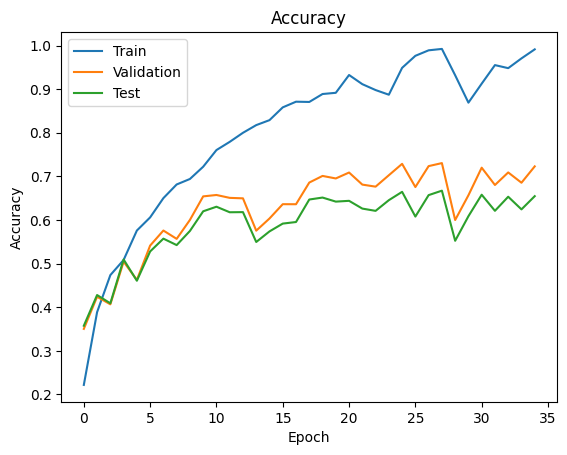

In [15]:
# accuracy plot
plt.plot(range(len(train_accs)), train_accs, label='Train')
plt.plot(range(len(val_accs)), val_accs, label='Validation')
plt.plot(range(len(test_accs)), test_accs, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("Q1_acc" )

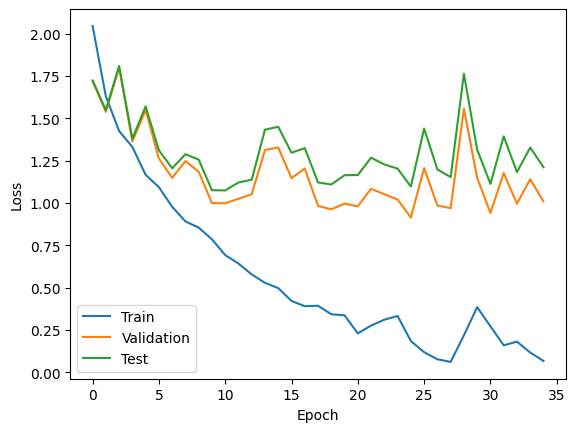

In [16]:
# Plot the accuracy and loss curves
#plt.figure(figsize=(15,5))
#plt.subplot(1,2,1)
# plt.plot(range(len(train_accs)), train_accs, label='Train')
# plt.plot(range(len(val_accs)), val_accs, label='Validation')
# plt.plot(range(len(test_accs)), test_accs, label='Test')
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.subplot(1,2,2)
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(val_losses)), val_losses, label='Validation')
plt.plot(range(len(test_losses)), test_losses, label='Test')
#plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.show()
plt.savefig("Q1_loss" )


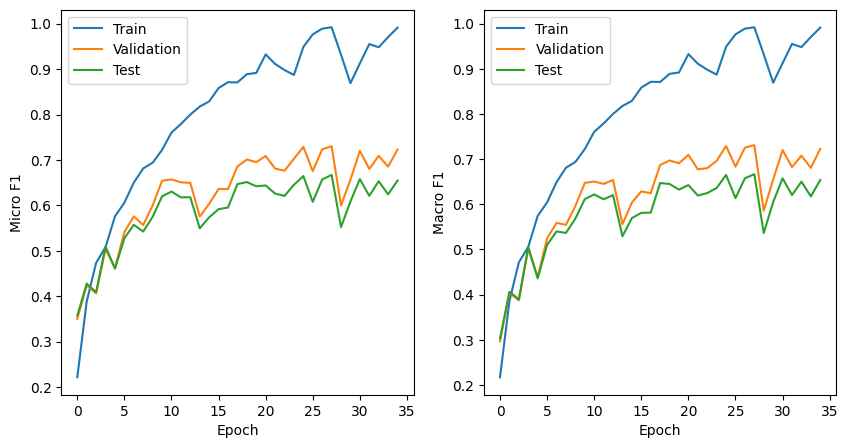

In [17]:
# Plot the micro and macro F1 curves
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(len(train_micro_f1s)), train_micro_f1s, label='Train')
plt.plot(range(len(val_micro_f1s)), val_micro_f1s, label='Validation')
plt.plot(range(len(test_micro_f1s)), test_micro_f1s, label='Test')
#plt.title('Micro F1')
plt.xlabel('Epoch')
plt.ylabel('Micro F1')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(train_macro_f1s)), train_macro_f1s, label='Train')
plt.plot(range(len(val_macro_f1s)), val_macro_f1s, label='Validation')
plt.plot(range(len(test_macro_f1s)), test_macro_f1s, label='Test')
#plt.title('Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.legend()
#plt.show()
plt.savefig("Q1_micro_macro")

In [18]:
# Print the confusion matrix
conf_matrix = confusion_matrix(test_targets, test_preds)
print(conf_matrix)

[[771  60  55  21   9   4   6   4  31  39]
 [  7 919   3   9   0   1   2   2   9  48]
 [ 98  23 586  73  56  57  60  20  11  16]
 [ 46  36  86 510  44 139  72  26  13  28]
 [ 39  19 113  81 558  25  76  75  12   2]
 [ 18  25 100 214  40 502  35  44   7  15]
 [ 19  19  81  85  37  22 723   2   9   3]
 [ 39  28  47  60  79  73  11 618   5  40]
 [114  95  11  28   6   8   8   2 693  35]
 [ 40 223   9  20   5   7   9   4  17 666]]


In [19]:
# Print the classification report
class_report = classification_report(test_targets, test_preds)
print(class_report)

              precision    recall  f1-score   support

           0       0.65      0.77      0.70      1000
           1       0.64      0.92      0.75      1000
           2       0.54      0.59      0.56      1000
           3       0.46      0.51      0.49      1000
           4       0.67      0.56      0.61      1000
           5       0.60      0.50      0.55      1000
           6       0.72      0.72      0.72      1000
           7       0.78      0.62      0.69      1000
           8       0.86      0.69      0.77      1000
           9       0.75      0.67      0.70      1000

    accuracy                           0.65     10000
   macro avg       0.67      0.65      0.65     10000
weighted avg       0.67      0.65      0.65     10000

